# DaKanjiRecognizer - Single Kanji CNN : Training
## Setup

Import the needed libraries.

In [1]:
#std lib
import sys
import os
import time
import datetime

#ML
import tensorflow as tf
import numpy as np

from PIL import Image

# data augmentation
from erasing import random_erasing

#plotting/showing graphics
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

Enable mixed precision.

In [2]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


Because the data sets are big let's make sure that the GPU is available to speed up training.

In [3]:
print("GPUs Available: ", tf.test.gpu_device_name())

GPUs Available:  /device:GPU:0


## Setting up the Data pipeline

Read the labels for each class from file.

In [4]:
labels_1, labels_2, labels = [], [], []

# load labels from file
with open(r'F:\data_sets\etlcdb\encoding_1.txt', mode="r", encoding="utf-8") as f:
    labels_1 = list(eval(f.read()).keys())
with open(r'F:\data_sets\etlcdb\encoding_2.txt', mode="r", encoding="utf-8") as f:
    labels_2 = list(eval(f.read()).keys())

ls = labels_1 + labels_2
# order the labels
indexs = sorted([str(i) for i in range(0, len(ls))])
ordered_labels = [ls[int(i)] for i in indexs]

# save the labels to text files
with open(r'E:\projects\DaKanjiRecognizerML\single_kanji_cnn\labels.txt', mode="w+", encoding="utf-8") as f:  
    f.write(''.join(ls))

Create a `tf.keras.dataset` from the saved files for test and validation.

In [6]:
#batch size
bs=1024
h, w = 64, 64
# class names
classes = [str(i) for i in range(len(ls))]

In [7]:
#define a font to show japanese characters in matplotlib figures
import matplotlib.font_manager as fm
show_sample_font = fm.FontProperties(fname=os.path.join("..", "fonts", "NotoSerifCJKjp-Regular.otf"), size=20)

def show_image(img : np.array, label : str):
    plt.figure(figsize=(2.2, 2.2))
    plt.title(label=label, font=show_sample_font)
    plt.axis("off")
    plt.imshow(img.astype(np.float64), cmap="gray")

## Preprocessing functions and data generator

In [145]:
def image_augmentation(x : tf.Tensor):
    """
    Augments the given image `x` randomly by applying:
        * erasing augmentation
        * elastic distortion
        
    Args:
        x : The image which should be augmented
        
    Returns:
        The augmented image.
    """
    
    x = x / tf.math.reduce_max(x)
    x = random_erasing(x, probability=1, sl = 0.02, sh = 0.15, method="black")
    
    
    return x

In [146]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=(0.0, 1.0),
    shear_range=30.0,
    channel_shift_range=0.5,
    fill_mode="constant",
    cval=0.0,
    preprocessing_function=image_augmentation,
    data_format="channels_last",
    validation_split=0.85
)

## create train dataset

## create validation dataset

In [147]:
val_datagen = datagen.flow_from_directory(
    r'F:\data_sets\etlcdb_test',
    target_size=(h, w),
    batch_size=32,
    class_mode="categorical",
    classes=classes,
    subset="validation"
)

Found 15240 images belonging to 6507 classes.


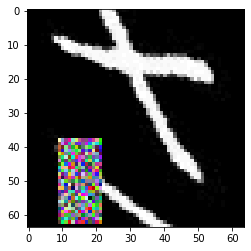

In [149]:
for i, l in val_datagen:
    plt.imshow(i[0] / i[0].max())
    break

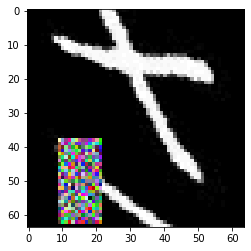

In [166]:
val_dataset = tf.data.Dataset.from_generator(
    lambda: val_datagen,
    output_types = (tf.float32, tf.float32),
    output_shapes = ([None, 64, 64, 1], [None, len(classes)]),
)

val_dataset = val_dataset.map(lambda x, y : (tf.cast(x, dtype=tf.float16), tf.cast(y, dtype=tf.float16)))
val_dataset = val_dataset.cache(r"F:\data_sets\etlcdb_cache\cache_test")
val_dataset = val_dataset.shuffle(buffer_size=bs*2)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print(val_dataset.take(1))

## Defining and training the CNN
First create image augmentation layers.

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomZoom, RandomRotation, RandomTranslation

img_augmentation = tf.keras.Sequential(
    [
        # resize images and rescale values
        Resizing(64, 64, "lanczos3"),
        Rescaling(scale=1.0/255),

        # random data augmentation
        RandomZoom(height_factor=(-0.2, 1.0), width_factor=(-0.2, 1.0), 
            fill_mode='constant', interpolation='bilinear', fill_value=0.0
        ),
        RandomTranslation(0.2, 0.2, fill_mode="constant"),
        RandomRotation(factor=(-0.1, 0.1) , fill_mode='constant', interpolation='bilinear'),
        
    ],
    name = "img_augmentation"
)

Make sure the image augmentaiton layers are working.

In [ ]:
imgs, lbs = [], []
for images, labels in val.take(1):
    for img, label in zip(images, labels):
        imgs.append(img.numpy())
        lbs.append(label.numpy())

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(9):
    augmented_images = img_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().reshape((64, 64)).astype(np.float64), cmap="gray")
    plt.axis("off")

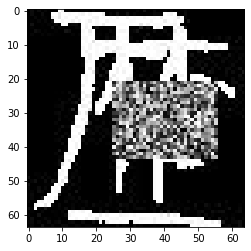

In [13]:
# load a sample
sample = tf.keras.preprocessing.image.load_img(
    path= r"F:\data_sets\etlcdb\1540\42.jpg",
    color_mode="grayscale",
    target_size=(64, 64)
)

sample = tf.keras.preprocessing.image.img_to_array(sample)
sample = sample.reshape((64, 64, 1)) / 255

sample = random_erasing(sample, probability=1.0, sl = 0.02, sh = 0.3, method="random")

plt.imshow(sample.numpy().reshape((64, 64)).astype(np.float64), cmap="gray")


Create an EfficientNetLite

In [15]:
from efficientnet_lite import EfficientNetLiteB0

eff_net_lite = EfficientNetLiteB0(
    include_top=True,
    weights=None,
    input_shape=(64, 64, 1),
    classes=len(ls),
    pooling="max",
    classifier_activation="softmax"
)

Merge EfficientNet and preprocessing layers to one model.

In [16]:
inputs = tf.keras.layers.Input(shape=(None, None, 1))
x = img_augmentation(inputs)
outputs = eff_net_lite(x)

f16_model = tf.keras.Model(inputs, outputs, name="EfficientNet")

f16_model.summary()

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
img_augmentation (Sequential (None, 64, 64, 1)         0         
_________________________________________________________________
efficientnetlite0 (Functiona (None, 6543)              11794031  
Total params: 11,794,031
Trainable params: 11,752,015
Non-trainable params: 42,016
_________________________________________________________________


Optionally load stored weights to resume training.

In [17]:
#path where the model should be saved
model_dir = os.path.join(os.getcwd(), "model")
print("model_dir:", model_dir)

model_dir: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model


In [25]:
#f16_model.load_weights(os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-14-0.94.hdf5"))

Set the optimizer, loss function and compile the model

In [18]:
l_r = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=l_r)

METRICS = [
    'accuracy', 
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

f16_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=METRICS)

Create a learning rate scheduler.

In [19]:
def scheduler(epoch, lr):
    return l_r - ((l_r / 100 * 4) * (epoch // 3))

scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
callbacks_list = [scheduler_callback]

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

#checkpoints setup
filepath = os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list.append(checkpoint)

print("checkpoints dir:", filepath)

checkpoints dir: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\checkpoints_own_cnn\weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5


Optionally enable tensorboard to track the progress of the model.

In [21]:
# load the tensorboard extension
%load_ext tensorboard

# add the tensorboard callback
log_dir = os.path.join(model_dir, "tf", "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks_list.append(tensorboard_callback)

print("tensorboard log dir:", log_dir)

tensorboard log dir: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\logs\20210627-114618


Finally train the model on the data set (in case of an Interrupt creates checkpoints).

In [24]:
#train the model
hist_3 = f16_model.fit(
    train,
    validation_data=val,
    epochs=100,
    initial_epoch=75,
    workers=16,
    use_multiprocessing=True,
    callbacks=callbacks_list
)

E:\projects\DaKanjiRecognizerML\.venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 76/100

Epoch 00076: LearningRateScheduler reducing learning rate to 0.0.
2979/2979 [==============================] - 2089s 672ms/step - loss: 0.0239 - accuracy: 0.9924 - precision: 0.9935 - recall: 0.9915 - val_loss: 0.1431 - val_accuracy: 0.9635 - val_precision: 0.9732 - val_recall: 0.9594

Epoch 00076: val_accuracy did not improve from 0.96612
Epoch 77/100

Epoch 00077: LearningRateScheduler reducing learning rate to 0.0.
2979/2979 [==============================] - 2054s 662ms/step - loss: 0.0241 - accuracy: 0.9923 - precision: 0.9935 - recall: 0.9916 - val_loss: 0.1425 - val_accuracy: 0.9638 - val_precision: 0.9733 - val_recall: 0.9597

Epoch 00077: val_accuracy did not improve from 0.96612
Epoch 78/100

Epoch 00078: LearningRateScheduler reducing learning rate to 0.0.
2979/2979 [==============================] - 2156s 695ms/step - loss: 0.0241 - accuracy: 0.9923 - precision: 0.9934 - recall: 0.9915 - val_loss: 0.1446 - val_accuracy: 0.9633 - val_precision: 0.9730 - val_rec


Epoch 00096: val_accuracy did not improve from 0.96612
Epoch 97/100

Epoch 00097: LearningRateScheduler reducing learning rate to -0.0002800000000000001.
2979/2979 [==============================] - 2048s 659ms/step - loss: inf - accuracy: 2.0360e-04 - precision: 2.0360e-04 - recall: 2.0360e-04 - val_loss: inf - val_accuracy: 2.0250e-04 - val_precision: 2.0250e-04 - val_recall: 2.0250e-04

Epoch 00097: val_accuracy did not improve from 0.96612
Epoch 98/100

Epoch 00098: LearningRateScheduler reducing learning rate to -0.0002800000000000001.
2979/2979 [==============================] - 2049s 660ms/step - loss: inf - accuracy: 2.0229e-04 - precision: 2.0229e-04 - recall: 2.0229e-04 - val_loss: inf - val_accuracy: 2.1551e-04 - val_precision: 2.1551e-04 - val_recall: 2.1551e-04

Epoch 00098: val_accuracy did not improve from 0.96612
Epoch 99/100

Epoch 00099: LearningRateScheduler reducing learning rate to -0.0002800000000000001.
 707/2979 [======>.......................] - ETA: 22:12 - l

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (Cast_8:0) = ] [[0 0 0...]...] [y (Cast_10/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_619/assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_less_equal/Assert/AssertGuard/pivot_f/_631/_83]]
  (1) Invalid argument:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (Cast_8:0) = ] [[0 0 0...]...] [y (Cast_10/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_619/assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_28838]

Function call stack:
train_function -> train_function


## Evaluating the model

After training plot the loss and accuracy for the test and validation sets.

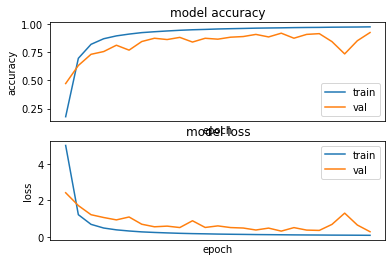

In [34]:
fig, axs = plt.subplots(2)

# accuracy
axs[0].plot(hist.history['accuracy'])
axs[0].plot(hist.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'], loc='lower right')
axs[0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)

# loss
axs[1].plot(hist.history['loss'])
axs[1].plot(hist.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper right')
axs[1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)


The graphs look good.
Let's now make a prediction.

In [40]:
# reload values from file if necessary
#f16_model.load_weights(os.path.join(model_dir, "tf", "checkpoints_own_cnn", "weights-improvement-73-0.97.hdf5"))
#f16_model.compile()

['茜', '茎', '雀', '隼', '侭', '隻', '雁', '雄', '隣', '式']


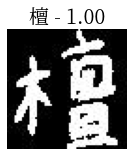

In [42]:
# load a sample
sample = tf.keras.preprocessing.image.load_img(
    path= r"F:\data_sets\etlcdb\1540\42.jpg",
    color_mode="grayscale",
    target_size=(64, 64)
)

sample = tf.keras.preprocessing.image.img_to_array(sample)
sample = sample.reshape((1, 64, 64, 1)) / 255

# run inference
prediction = eff_net_lite.predict(sample)[0]

# output 10 most liekly predictions
ind = np.argpartition(prediction, -10)[-10:]
q = ind[np.argsort(prediction[ind])]
print([ordered_labels[i] for i in reversed(q)])

# show the most confident prediction and the image
show_image(sample.reshape((64, 64)), ls[prediction.argmax()] + " - %.2f" % prediction.max())

## Saving the model

The model is perfoming very well therefore save the trained model as a "*.pb" file.

In [43]:
eff_net_lite.save(
    os.path.join(model_dir, "tf", "trained_model"),
)

E:\projects\DaKanjiRecognizerML\.venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\trained_model\assets


Finally convert the model to a TF-Light model to be used in applications.

In [46]:
# set the dtype policy to float32
policy = tf.keras.mixed_precision.Policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

# Create a new EfficientNet Lite (with float 32) and restore the weights
eff = tf.keras.Sequential([EfficientNetLiteB0(
    include_top=True,
    weights=None,
    input_shape=(64, 64, 1),
    classes=len(ls),
    pooling="max",
    classifier_activation="softmax"
)])
eff.set_weights(f16_model.get_weights())

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(eff)

# set quantization, additional ops
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

# Save the model.
print(os.path.join(model_dir, "tflite", "model.tflite"))
with open(os.path.join(model_dir, "tflite", "model.tflite"), 'wb') as f:
  f.write(tflite_model)


E:\projects\DaKanjiRecognizerML\.venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: C:\Users\dario\AppData\Local\Temp\tmp5d1atjyc\assets
E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tflite\model.tflite


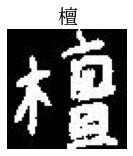

In [48]:
# create a tf lite interpreter
interpreter = tf.lite.Interpreter(os.path.join(model_dir, "tflite", "model.tflite"))
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = sample
interpreter.set_tensor(input_details[0]['index'], input_data)

# run interpreter
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# show prediction
show_image(sample.reshape(64, 64), ls[output_data.argmax()])